# Project analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import settings
from dataprocessor import load_repo_commits, load_project_commits
from project import get_project_output_dir_by_name, get_project_path

Set your project and repo config here

In [2]:
PROJECT_NAME = 'pydata-project'
pd.DataFrame.from_csv

<bound method DataFrame.from_csv of <class 'pandas.core.frame.DataFrame'>>

Load repo TSV file

In [3]:
df = load_project_commits(get_project_path(PROJECT_NAME))

Loading commits dataframe for ipython
/home/skupsala/code/gitlytic/venv/lib/python3.5/site-packages/pandas/core/frame.py:1251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  infer_datetime_format=infer_datetime_format)
Loading commits dataframe for scipy
Loading commits dataframe for notebook
Loading commits dataframe for pandas
Loading commits dataframe for numpy


In [4]:
df.set_index(['repo_name', 'author_email', 'commit_hash'], drop=False, inplace=True)

## Project overview
TODO
- TOP 10 contributors (3months, 2weeks)
  * How many commits
  * Percentage of commits
- Commmits per week chart over X weeks
- Commit message length distribution over all commits
- LOC over time
- Author count over time
- New authors per week for last X weeks
- Files over time
- Directories over time
- Fix commits over time

#### Commit and author count

In [5]:
total_commit_count = len(df)
print("Commit count: {}".format(total_commit_count))
total_author_count = df['author_email'].nunique()
print("Author count: {}".format(total_author_count))

Commit count: 83231
Author count: 2837


In [6]:
def get_top_contributors(df, top_count=10):
    commit_count = len(df)
    top_committers = df.groupby('author_email').size().sort_values(ascending=False)[:top_count].to_frame(name='commit_count')
    top_committers['percentage_of_commits'] = (top_committers['commit_count'] / commit_count) * 100.0
    return top_committers

In [7]:
repos_by_hour = {}
for repo_name, repo_df in df.groupby(level=0):
    print()
    print('-----------------------------------------------------------')
    print('Repo: {}'.format(repo_name))
    print('Commits: {}'.format(len(repo_df)))
    print('Authors: {}'.format(repo_df['author_email'].nunique()))
    oldest_commit = repo_df.iloc[-1]
    age_delta = datetime.now() - oldest_commit.author_date.to_pydatetime()
    age_delta_years = age_delta.days // 366 # This is not exact - precise enough for this purpose
    print('Age: {years} year(s) and {days} day(s)'.format(years=age_delta_years, days=(age_delta.days-age_delta_years*365)))
    print('First commit was written {} by {}'.format(oldest_commit.author_date.to_pydatetime(), oldest_commit.author_name))
    print('For nostalgy, here it is:')
    print(oldest_commit.subject)
    print()
    print('Since that a lot have happened...')
    TOP_COUNT = 5
    print('Here you see top {} contributors portion of the contributions'.format(TOP_COUNT))
    repo_top_contributors = get_top_contributors(repo_df, top_count=TOP_COUNT)
    print(repo_top_contributors.sum())
    print(repo_top_contributors)
    print()
    print('Last three months top {} contributors'.format(TOP_COUNT))
    last_three_months_commits = repo_df[repo_df['author_date'] >= (datetime.today() - timedelta(days=3 * 30))]
    last_three_months_top_contributors = get_top_contributors(last_three_months_commits, top_count=TOP_COUNT)
    print(last_three_months_top_contributors)
    print()
    print('Last two weeks top {} contributors'.format(TOP_COUNT))
    last_two_weeks_commits = repo_df[repo_df['author_date'] >= (datetime.today() - timedelta(days=14))]
    last_two_weeks_top_contributors = get_top_contributors(last_two_weeks_commits, top_count=TOP_COUNT)
    print(last_two_weeks_top_contributors)
    author_date_index = pd.DatetimeIndex(repo_df['author_date'])
    repos_by_hour[repo_name] = repo_df.groupby(author_date_index.hour)['author_email'].count()
    


-----------------------------------------------------------
Repo: ipython
Commits: 22829
Authors: 656
Age: 12 year(s) and 73 day(s)
First commit was written 2005-07-06 17:52:32 by fperez
For nostalgy, here it is:
Reorganized the directory for ipython/ to have its own dir, which is a bit more consistent with the SVN book recommended layout.

Since that a lot have happened...
Here you see top 5 contributors portion of the contributions
commit_count             14174.000000
percentage_of_commits       62.087695
dtype: float64
                              commit_count  percentage_of_commits
author_email                                                     
benjaminrk@gmail.com                  5562              24.363748
takowl@gmail.com                      2949              12.917780
bussonniermatthias@gmail.com          2431              10.648736
ellisonbg@gmail.com                   1762               7.718253
jdfreder@calpoly.edu                  1470               6.439178

Last th

/home/skupsala/code/gitlytic/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: 'author_email' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


### Commits over time

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

<IPython.core.display.Javascript object>


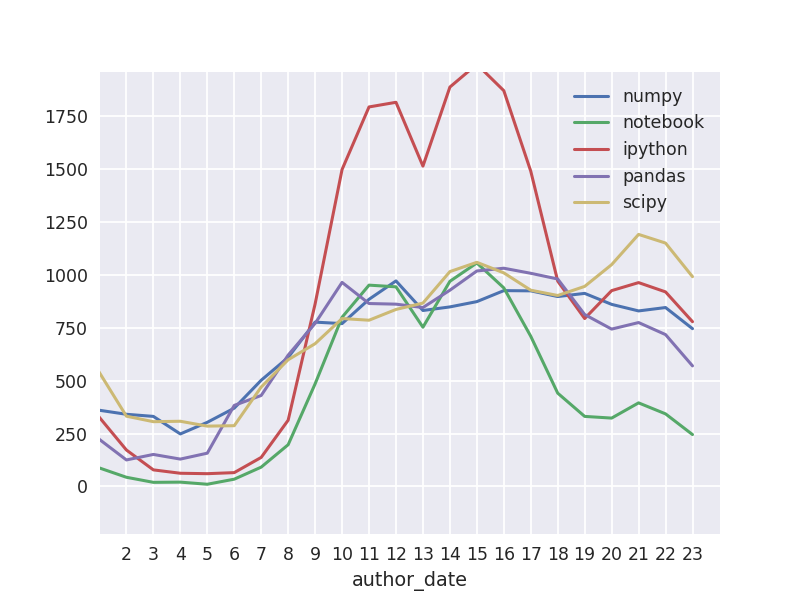

In [9]:
for repo_name, by_hour in repos_by_hour.items():
    ax = by_hour.plot(xticks=np.arange(24), label=repo_name)
    ax.legend()